In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as soup
from typing import List, Union, Dict

In [2]:
periods = [str(i) for i in list(range(1957, 2017))]

In [3]:
import numpy as np
from KYOTO.libraries.dst import DstExtraction
from utils.rw_processed_data import load_processed_data, save_processed_data
classification_rules = {
    'fraca':            np.array(range(-31, -51, -1)),
    'moderada':         np.array(range(-51, -101, -1)),
    'intensa':          np.array(range(-101, -251, -1)),
    'super_intensa':    np.array(range(-251, -1001, -1)),
}

# dst = DstExtraction(periods=periods)
# dst.make_classification(classification_rules)

# A base completa com os dados de Dst estão neste arquivo: dst_full_data
df_filtered = load_processed_data(folder_name='KYOTO', name='dst_full_data')

In [4]:
import numpy as np
from KYOTO.libraries.kp import KpExtraction

# kp = KpExtraction(periods=periods)

# result = pd.merge(left=dst_test, right=kp_test, on='date')
# save_processed_data(df=result, folder_name='KYOTO', name='dst_kp_merged')
# kp_test['date'] # = pd.to_datetime(kp_test['date'])
dst_kp_full = load_processed_data(folder_name='KYOTO', name='dst_kp_merged')

In [5]:
dst_kp_full

,0,1,2,3,4,5,6,7,8,9,...,dst_min,classification,0,3,6,9,12,15,18,21
0,-49,-30,-27,-28,-26,-21,-20,-16,-11,-6,...,-49,fraca,3.333,2.333,3.333,2.667,1.667,3.333,4.333,4.333
1,-34,-46,-41,-41,-45,-43,-45,-39,-36,-36,...,-46,fraca,4.333,4.667,3.000,2.000,3.333,2.333,3.333,3.000
2,-33,-32,-32,-37,-35,-30,-31,-29,-35,-34,...,-37,fraca,3.000,3.000,3.333,3.333,2.333,3.333,3.667,3.333
3,-27,-31,-32,-33,-36,-34,-32,-30,-29,-25,...,-36,fraca,2.667,2.667,2.000,2.000,1.000,1.333,2.333,2.000
4,-34,-20,-19,-19,-17,-16,-14,-12,-12,-9,...,-34,fraca,0.000,0.333,0.667,0.333,1.000,1.333,2.333,2.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7824,-38,-19,-17,-19,-17,-14,-11,-12,-17,-18,...,-38,fraca,2.667,1.000,1.333,1.667,0.667,1.000,2.000,3.000
7825,-29,-33,-31,-34,-36,-38,-33,-37,-32,-31,...,-38,fraca,2.000,4.333,4.000,2.000,1.667,0.667,2.000,3.333
7826,-75,-2,-4,-4,-8,-14,-11,-9,-14,-31,...,-84,moderada,2.333,3.667,4.333,4.333,4.667,4.333,5.000,4.667
7827,-46,-66,-65,-71,-71,-68,-65,-68,-61,-59,...,-71,moderada,3.667,4.333,4.667,3.333,2.333,2.667,4.000,2.333


In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
def class_count(df: pd.DataFrame):
    count = {"fraca": 0, "moderada": 0, "intensa": 0, "super_intensa": 0}
    for i in range(1, len(df)):
        count[df['classification'].iloc[i]]+=1
    print(count)

In [8]:
class_count(dst_kp_full)

{'fraca': 4479, 'moderada': 2703, 'intensa': 592, 'super_intensa': 54}


In [9]:
def accuracy_range(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
    print(results)
    print('--------------------------------------------------------------')

In [10]:
def precision_range(results):
  mean = results.mean()
  dv = results.std()
  print('Precisão média: {:.2f}%'.format(mean*100))
  print('Intervalo de precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
  print(results)
  print('--------------------------------------------------------------')

In [11]:
def recall_range(results):
  mean = results.mean()
  dv = results.std()
  print('Recall médio: {:.2f}%'.format(mean*100))
  print('Intervalo de recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
  print(results)
  print('--------------------------------------------------------------')

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [13]:
import sklearn.base, sklearn.model_selection
def cros_val_scoring(model: sklearn.base.BaseEstimator, x: any, y:any, cv: int):
    accuracy = cross_val_score(model, x, y, cv = cv, scoring='accuracy')
    precision = cross_val_score(model, x, y, cv = cv, scoring='precision_macro')
    recall = cross_val_score(model, x, y, cv = cv, scoring='recall_macro')

    accuracy_range(accuracy)
    precision_range(precision)
    recall_range(recall)

In [14]:
def model_evaluation(y_train, y_test, y_pred, partition: str):
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)

    if partition == 'tr':
        print("\nRelatório de Classificação do modelo final:\n\n", classification_report(y_train, y_pred, digits=4))
        matrix = confusion_matrix(y_train, y_pred)

    if partition == 'te':
        print("\nRelatório de Classificação do modelo final:\n\n", classification_report(y_test, y_pred, digits=4))
        matrix = confusion_matrix(y_test, y_pred)
        

    #Matriz de confusão
    fig, ax = plt.subplots()
    sns.heatmap(matrix, annot=True, ax=ax, fmt='d', cmap='Reds')

    ax.set_title("Matriz de Confusão", fontsize=18)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted Label")

    plt.tight_layout()

In [15]:
#MODELO DST-MIN -> Dst class
def dst_min_model():
    #Codificação da classe alvo
    le = LabelEncoder()
    df_filtered['classification'] = le.fit_transform(df_filtered['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = df_filtered['dst_min'].values.reshape(-1, 1) 
    y = df_filtered['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    #cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [16]:
#MODELO DST -> Dst class
def dst_model():
    #Codificação da classe alvo
    le = LabelEncoder()
    df_filtered['classification'] = le.fit_transform(df_filtered['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = df_filtered[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]]
    y = df_filtered['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

   #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [17]:
def kp_max(df: pd.DataFrame):    
    df.insert(35, 'kp_max', np.zeros(len(df)))
    for i in range(1, len(df)):
        df.loc[i, 'kp_max'] = max(df.loc[i, '0'], df.loc[i, '3'], df.loc[i, '6'], df.loc[i, '9'], df.loc[i, '12'], df.loc[i, '15'], df.loc[i, '18'], df.loc[i, '21'])

kp_max(dst_kp_full)

In [18]:
#MODELO KP -> Dst class

def kp_model():

    #Codificação da classe alvo
    le = LabelEncoder()
    dst_kp_full['classification'] = le.fit_transform(dst_kp_full['classification'])

    X = dst_kp_full[['0','3','6','9','12','15','18','21']].copy()
    y = dst_kp_full['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

   #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [ ]:
#MODELO KP-MAX -> Dst class
def kp_max_model() :
    #Codificação da classe alvo
    le = LabelEncoder()
    dst_kp_full['classification'] = le.fit_transform(dst_kp_full['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = dst_kp_full['kp_max'].values.reshape(-1, 1) 
    y = dst_kp_full['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

In [ ]:
#MODELO DST_KP-MAX

def dstMin_kpMax_model() :
    #Codificação da classe alvo
    le = LabelEncoder()
    dst_kp_full['classification'] = le.fit_transform(dst_kp_full['classification'])

    # Divisao entre treino/teste e avaliação do dataframe original
    X = dst_kp_full[['dst_min','kp_max']]
    y = dst_kp_full['classification']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y)

    print('O dataset de treino possui {} tempestades e o de teste {} tempestades.'.format(X_train.shape[0], X_test.shape[0]))
    print('--------------------------------------------------------------')

    #Definições de modelo e método de validação cruzada
    SEED = 10
    np.random.seed(SEED)
    cv = StratifiedKFold(n_splits=5, shuffle=True)

    model = GaussianNB()

    #Scoring médio dos modelos treinados na validação cruzada
    cros_val_scoring(model, X_train, y_train, cv)  

    
    #Relatório de classificação -> Desempenho por classes | Modelo em treinamento (Partição de treino do dataset)
    #y_pred = cross_val_predict(model, X_train, y_train, cv = cv)
    
    #Relatório de Classificação -> Desempenho por classes | Modelo Final (Usando a partição de avaliação do dataset)
    np.random.seed(SEED)
    final_model = GaussianNB()
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    y_prob = final_model.predict_proba(X_test)

    model_evaluation(y_train, y_test, y_pred, 'te') # 'tr' para treino e 'te' para teste

O dataset de treino possui 5480 tempestades e o de teste 2349 tempestades.
--------------------------------------------------------------
Acurácia média: 86.46%
Intervalo de acurácia: [84.05% ~ 88.87%]
[0.86222628 0.84854015 0.88594891 0.86405109 0.86222628]
--------------------------------------------------------------
Precisão média: 75.64%
Intervalo de precisão: [69.83% ~ 81.45%]
[0.80657217 0.73984613 0.7641816  0.71978924 0.75157482]
--------------------------------------------------------------
Recall médio: 87.09%
Intervalo de recall: [84.32% ~ 89.86%]
[0.8831549  0.87823469 0.84436024 0.87786869 0.87092057]
--------------------------------------------------------------

Relatório de Classificação do modelo final:

               precision    recall  f1-score   support

           0     0.9009    0.9263    0.9134      1344
           1     0.7072    0.8820    0.7850       178
           2     0.8619    0.7620    0.8089       811
           3     0.5357    0.9375    0.6818       

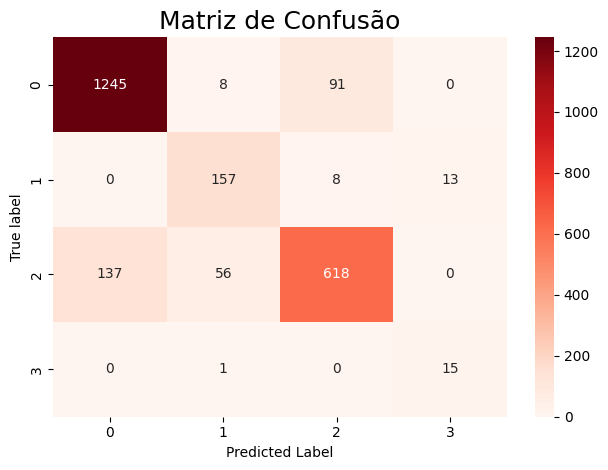

In [20]:
#MODELOS

dst_model()
#dst_min_model()
#kp_model()
#kp_max_model();
#dstMin_kpMax_model()

O dataset de treino possui 5480 tempestades e o de teste 2349 tempestades.
--------------------------------------------------------------

Relatório de Classificação do modelo final:

               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1344
           1     0.9312    0.9888    0.9591       178
           2     1.0000    0.9840    0.9919       811
           3     0.8889    1.0000    0.9412        16

    accuracy                         0.9936      2349
   macro avg     0.9550    0.9932    0.9731      2349
weighted avg     0.9940    0.9936    0.9937      2349



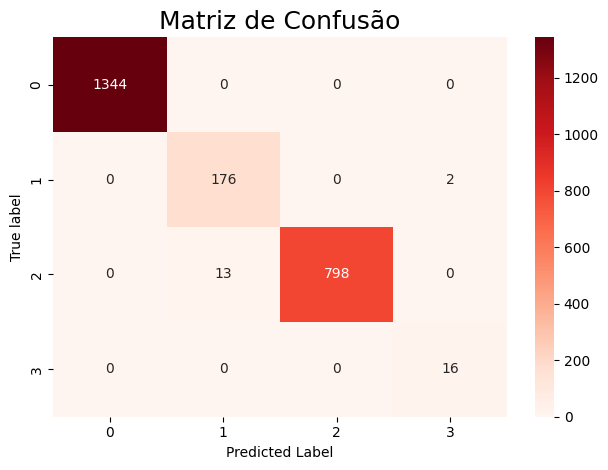

In [19]:
# dst_min_model()